In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

In [15]:
h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[i + 1] - 1) for i in range(n - 1)])
def effective_hem(size, J):
    hem = np.zeros((2**size, 2**size))
    for i in range(2**size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1)**int(i) for i in binary]
        hem[i,i] = h(size, J, Z)
    return hem
print(effective_hem(4,[1,1,1]))

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  8.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  8. 

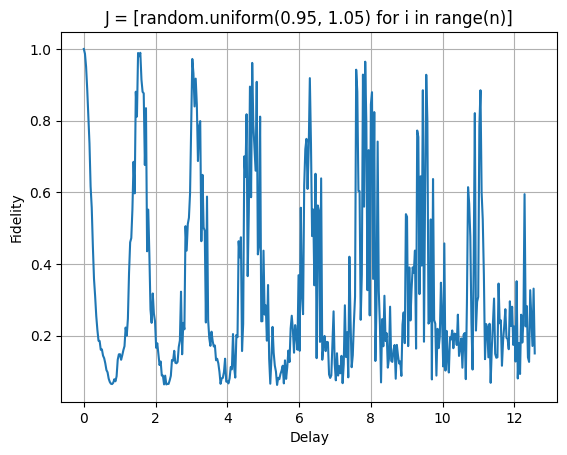

In [44]:
from scipy.linalg import expm
import random

delay = np.linspace(0,4*np.pi,400)

fid = []
n = 4
for t in delay:
    #qr = QuantumRegister(n)
    #cr = ClassicalRegister(n)
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)

    U = expm((-1j*t)*effective_hem(n,[random.uniform(0.95, 1.06) for i in range(n)]))
    U = qi.Operator(U)

    qc.unitary(U, [i for i in range(n)])

    for i in range(n):
        qc.h(i)
    qc.measure_all()
    #qc.measure(qr[1],cr[1])

    #Simulator
    qcomp = Aer.get_backend("qasm_simulator")
    result = qiskit.execute(qc, Aer.get_backend('qasm_simulator'), shots=8000).result()
    fid.append(result.get_counts().get('0000',0)/8000)

plt.grid()
plt.ylabel('Fidelity')
plt.xlabel('Delay')
plt.title('J = [random.uniform(0.95, 1.05) for i in range(n)]')
plt.plot(delay,fid)

In [ ]:
print()